In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
# Libraries 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, pathlib

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
# Get the horses-or-humans dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

In [ ]:
# Get the validation-horses-or-humans dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip

In [ ]:
# Unzip the zip files
!unzip horse-or-human.zip
!unzip validation-horse-or-human.zip

In [ ]:
from tensorflow.keras.preprocessing import image
humans_train_test_path = '/content/humans/'

# Get the human images from specified folder for training
human_train = []
for filename in os.listdir(humans_train_test_path):
  if filename.endswith(".png"):
    img = image.load_img(humans_train_test_path+filename, target_size = (224,224,3))
    human_train.append(image.img_to_array(img))

human_train = np.array(human_train)

# Get 200 of the human images from specified folder for testing
human_test = []
imagesLimit = 1
for filename in os.listdir(humans_train_test_path):
  if filename.endswith(".png"):
    img = image.load_img(humans_train_test_path+filename, target_size = (224,224,3))
    human_test.append(image.img_to_array(img))
    if imagesLimit == 200:
      break
    imagesLimit += 1

human_test = np.array(human_test)

In [ ]:
print(human_train.shape)
print(human_test.shape)

In [ ]:
human_train = human_train.astype('float32') /255.
human_test = human_test.astype('float32') /255.

In [ ]:
input_layer = tf.keras.Input(shape=(224, 224, 3), name="INPUT")
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = layers.MaxPooling2D((2, 2), name="CODE")(x)

x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
output_layer = layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [ ]:
humanAE = Model(input_layer ,output_layer)
humanAE.compile(optimizer="adam", loss="mse")
humanAE.summary()

In [ ]:
# Train the human Autoencoder
humanAE.fit(
    human_train, human_train,
    epochs = 30,
    batch_size=32,
    shuffle = True,
    validation_data = (human_test, human_test)

)

In [ ]:
# Save the model
humanAE.save("HumanAE.h5")

In [ ]:
# Model to get the encoded representation of a human
getEncodedHuman = Model(inputs=humanAE.input, outputs=humanAE.get_layer("CODE").output)

In [ ]:
# Get encoded humans
encodedHuman = getEncodedHuman.predict(human_test)
encodedHuman = encodedHuman.reshape((len(human_test), 6272))
encodedHuman.shape

In [ ]:
# Get reconstructed humans
reconstructedHumans = humanAE.predict(human_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

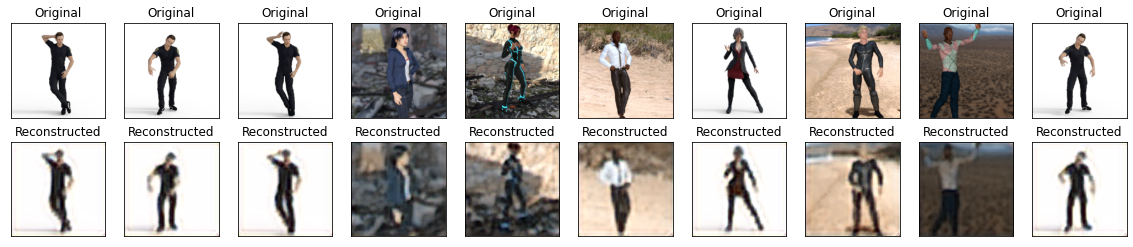

In [ ]:
# Visualize the human images
n=10
plt.figure(figsize=(20,4))
for i in range(n):
  # Display the original image
  ax = plt.subplot(2, n, i+1)
  plt.imshow(image.array_to_img(human_test[i]))
  plt.title('Original')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display the reconstructed image
  ax = plt.subplot(2, n, i + 1 + n)
  reconstructedHumans[i] = reconstructedHumans[i] / 255.
  plt.imshow(reconstructedHumans[i])
  plt.title("Reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()